In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import soundfile as sf
from tensorflow.keras import layers, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

def extract_song_embeddings(segment):
    _, embbedings, _ = yamnet_model(segment)
    song_embeddings = tf.reduce_mean(embbedings, axis=0)
        
    return song_embeddings.numpy()   

def extract_song_segments(file_path):
    segment_seconds = 5
    overlap_seconds = 0 
    segments = []

    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)

        segment_samples = segment_seconds * sr
        hop_samples = segment_samples - int(overlap_seconds * sr)

        for start in range(0, 
                           len(waveform) - segment_samples + 1, 
                           hop_samples):
                           
            segment = waveform[start: start + segment_samples]
            segments.append(segment)

        return segments
    
    except:
        print(f"Error has occured in file path {file_path}")
        return None

2026-01-13 22:19:20.865306: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-13 22:19:21.690919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 22:19:24.797309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/austine/Desktop/music-vibes-classification/env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/home/austine/Desktop/music-vibes-classification/env/lib/python3.13/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecat

In [2]:
dataset_path = "vibes"
dataset_csv_path = "song_embeddings.csv"

X = []
y = []
vibe_map = {"relaxing": 0,
             "chaotic": 1,
             "chill": 2,
             "energetic": 3,
             "acoustic": 4}

if not os.path.exists(dataset_csv_path):
    for vibe in os.listdir(dataset_path):
        vibe_path = os.path.join(dataset_path, vibe)
        for file in tqdm(os.listdir(vibe_path), desc=f"Extracting songs embedding in folder {vibe}"):
            file_path = os.path.join(vibe_path, file)
            segments = extract_song_segments(file_path)
            if segments is not None:
                for segment in segments:
                    embeddings = extract_song_embeddings(segment)
                    X.append(embeddings)
                    y.append(vibe_map[vibe])

Extracting songs embedding in folder relaxing:  39%|███▉      | 117/300 [01:00<01:10,  2.58it/s]/tmp/ipykernel_19200/4098649438.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(file_path, sr=16000, mono=True)
/home/austine/Desktop/music-vibes-classification/env/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting songs embedding in folder relaxing:  39%|███▉      | 118/300 [01:01<01:06,  2.74it/s]

Error has occured in file path vibes/relaxing/jazz.00054.wav


Extracting songs embedding in folder relaxing: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]


In [3]:
if not os.path.exists(dataset_csv_path):
    df = pd.DataFrame(X)
    df["label"] = y

    df.to_csv(dataset_csv_path)

In [4]:
df = pd.read_csv(dataset_csv_path,
                 index_col=0)

X = np.array(df.drop(columns=["label"]))
y = np.array(df["label"])

vibe_labels = ["Relaxing", 
               "Chaotic", 
               "Chill", 
               "Energetic",
               "Acoustic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.20,
                                                    stratify=y)

model = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(vibe_labels), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7555 - loss: 0.6514 - val_accuracy: 0.8114 - val_loss: 0.7284
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8155 - loss: 0.4971 - val_accuracy: 0.8266 - val_loss: 0.5157
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8404 - loss: 0.4407 - val_accuracy: 0.8234 - val_loss: 0.4892
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8497 - loss: 0.3992 - val_accuracy: 0.8419 - val_loss: 0.4376
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8589 - loss: 0.3814 - val_accuracy: 0.8579 - val_loss: 0.4008
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8675 - loss: 0.3622 - val_accuracy: 0.8403 - val_loss: 0.4300
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8719 - loss: 0.3398 - val_accuracy: 0.8523 - val_loss: 0.4092
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8786 - loss: 0.3182 - val_accuracy

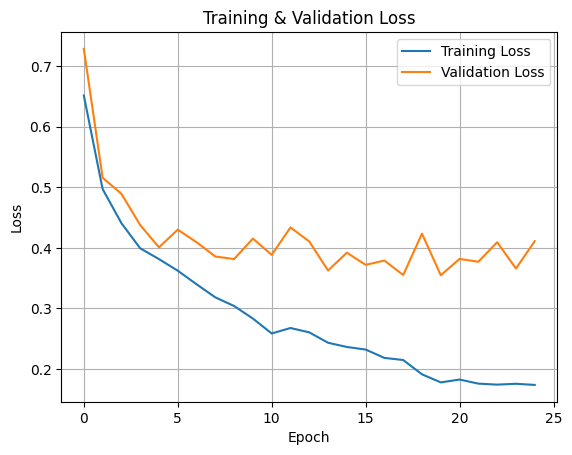

In [5]:
import matplotlib.pyplot as plt

# Get loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.grid()
plt.legend()
plt.show()

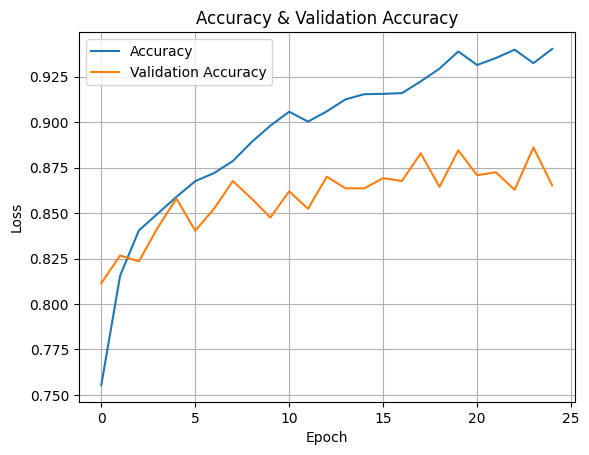

In [6]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy & Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Relaxing       0.90      0.96      0.93       358
     Chaotic       0.94      0.84      0.89       240
       Chill       0.93      0.86      0.89       360
   Energetic       0.85      0.89      0.87       359
    Acoustic       0.87      0.90      0.88       240

    accuracy                           0.89      1557
   macro avg       0.90      0.89      0.89      1557
weighted avg       0.89      0.89      0.89      1557



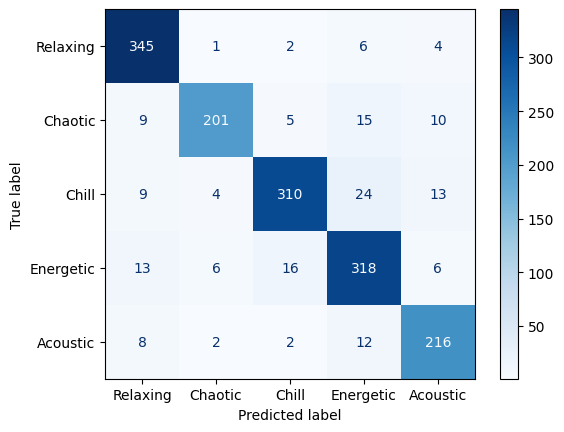

In [7]:
y_preds = model.predict(X_test)
y_pred_labels = np.argmax(y_preds, axis=1)

print(classification_report(y_test,
                            y_pred_labels,
                            target_names=vibe_labels))

cm = confusion_matrix(y_test,
                      y_pred_labels)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=vibe_labels)
cm_display.plot(cmap="Blues")

In [ ]:
z = []
song_segments = extract_song_segments("testing_dataset/kehlani.mp3")

for song_segment in song_segments:
    song_embeddings = extract_song_embeddings(song_segment)
    z.append(song_embeddings)

z = np.array(z)

y_pred = model.predict(z)

song_pred = np.mean(y_pred, axis=0)
y_pred_label = np.argmax(song_pred)

print("Predicted Class:", vibe_labels[y_pred_label])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class: Chaotic
